# FOREST COVER PREDICTION

## Import necessory packages

In [1]:
import warnings
import numpy as np
import pandas as pd
from collections import Counter 
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
from scipy import stats
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sb


In [2]:
#to remove warnings
warnings.simplefilter("ignore")

In [5]:
#collecting data from file
data = pd.read_csv("train.csv")

## Simple EDA checks

### 1.check the data is readed correctly or not

In [4]:
data.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5


### 2.checking for the data shape

In [5]:
data.shape

(15120, 56)

### 3.check the data have any null value 

In [6]:
data.isnull().sum()

Id                                    0
Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area1                      0
Wilderness_Area2                      0
Wilderness_Area3                      0
Wilderness_Area4                      0
Soil_Type1                            0
Soil_Type2                            0
Soil_Type3                            0
Soil_Type4                            0
Soil_Type5                            0
Soil_Type6                            0
Soil_Type7                            0
Soil_Type8                            0
Soil_Type9                            0
Soil_Type10                           0


from the above we can see that there is no null values in the data set

### 4.checking the data is balanced or not

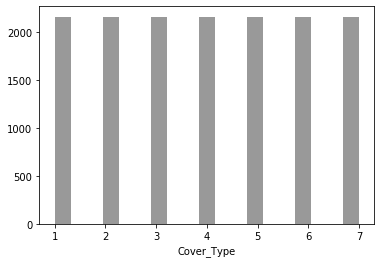

In [7]:
sb.distplot(data.Cover_Type,kde=False,color="black")

from the above graph we can see that the data is equeally distributed. hence it is a balanced data set

### 5.checking skewness and curtosis

In [8]:
print("skew of covertype : ",stats.skew(data.Cover_Type))
print("kurtosis of Covertypestats : ",stats.kurtosis(data.Cover_Type))

skew of covertype :  0.0
kurtosis of Covertypestats :  -1.25


our data output has a negative kurtosis

### assigning X and Y values

In [9]:
X = data.iloc[:,:-1]
y = data.Cover_Type

## 1.Droping features with no values


In [10]:
columns = X.columns
droped_columns = []
for col_name in  columns:
    mean = np.mean(X.loc[:,[col_name]])
    if mean.any() == 0.0:
        droped_columns.append(col_name)
        X.drop(col_name,axis = 1,inplace = True)
print("\n\nDropped Coloms = ",droped_columns)



Dropped Coloms =  ['Soil_Type7', 'Soil_Type15']


## 2.Findining Variance Threshold to drop features

In [11]:
# finding columns with low variance and droping those columns
varience = VarianceThreshold(0.003)
varience.fit(X)

VarianceThreshold(threshold=0.003)

In [12]:
var = varience.get_support()
print(var)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True False False  True
  True  True  True  True  True  True  True  True  True False  True  True
  True False  True False False  True  True  True  True  True False  True
 False False  True  True  True]


In [13]:
column_names= X.columns
X_var = X.copy()

In [14]:
rem_colmn = X_var.columns[varience.get_support() == False]
print("columns which has low varience : \n\n",rem_colmn)
print(X_var.drop(rem_colmn,inplace=True,axis=1))
print("we have dropped " +str(len(rem_colmn))+ " coloumns using threshold varience")
print("current shape of data set : ",X_var.shape)

columns which has low varience : 

 Index(['Soil_Type8', 'Soil_Type9', 'Soil_Type21', 'Soil_Type25', 'Soil_Type27',
       'Soil_Type28', 'Soil_Type34', 'Soil_Type36', 'Soil_Type37'],
      dtype='object')
None
we have dropped 9 coloumns using threshold varience
current shape of data set :  (15120, 44)


## 3.Converting all the values to a scale (std_scalar)

In [15]:
scale = StandardScaler()
scaled_X_var = scale.fit_transform(X_var)
scaled_X_var.shape

(15120, 44)

## 4.Finding PCA to drop Features

In [16]:
model = PCA(n_components=40)
X_scaled_pca = model.fit_transform(scaled_X_var)
X_scaled_pca = pd.DataFrame(scaled_X_var)
model.explained_variance_ratio_.sum()

0.9983722615885103

 while considering the first 40 components of PCA out we get 99.83 percent of total data

In [17]:
#reducing the columns to 40
X_scaled_pca = X_scaled_pca.iloc[:,:-4]
X_scaled_pca.shape

(15120, 40)

## Train_Test_Split

In [18]:
X_train,X_test,y_train,y_test = train_test_split(X_scaled_pca,y,random_state=10)


# MODELLING

## 1.Modelling with XGBoost

In [19]:
model = XGBClassifier()
model.fit(X_train,y_train)
y_predict = model.predict(X_test)
accuracy_score(y_test,y_predict)

0.8857142857142857

In [20]:
x = pd.crosstab(y_test,y_predict)
x

col_0,1,2,3,4,5,6,7
Cover_Type,,,,,,,
1,433,82,1,0,4,0,23
2,68,387,9,0,43,9,7
3,0,4,444,23,5,29,0
4,0,0,11,548,0,3,0
5,3,18,3,0,516,4,0
6,2,6,48,11,3,479,0
7,9,3,0,0,1,0,541


### finding percentage distribution for each catogory in output(Y)

In [21]:
for i in range(1,8):
        x1 = x[i].sum()
        x2 = x[1][1]/x1
        print("percentage considering ",i," is",x2*100)

percentage considering  1  is 84.07766990291262
percentage considering  2  is 86.6
percentage considering  3  is 83.91472868217055
percentage considering  4  is 74.39862542955326
percentage considering  5  is 75.6993006993007
percentage considering  6  is 82.63358778625954
percentage considering  7  is 75.83187390542906


## Finding Cross Validation Score

In [22]:
cross_val  = cross_val_score(model,X_scaled_pca,y,scoring="accuracy",cv=5)
print("cross_val_score : ",cross_val)
print("maximum accuracy : ",max(cross_val))
print("minimum accuracy : ",min(cross_val))
print("average accuracy : ",np.mean(cross_val))

cross_val_score :  [0.31911376 0.46825397 0.51653439 0.54133598 0.58267196]
maximum accuracy :  0.5826719576719577
minimum accuracy :  0.3191137566137566
average accuracy :  0.4855820105820106


eventhough, my XGBclassifier model gives 88 % in modelling but while considering cross validation score it gives a very small accurary hence XGB_classifier is not a good model for my data beacause this model leads to overfitting problem. |hence i change the model to Support_Vector_machine  

## 2.Modelling with SVM

In [23]:
model = SVC()
model.fit(X_train,y_train)
y_predict = model.predict(X_test)
accuracy_score(y_test,y_predict)

0.7412698412698413

In [24]:
#cross_tab
x = pd.crosstab(y_test,y_predict)
x

col_0,1,2,3,4,5,6,7
Cover_Type,,,,,,,
1,365,108,1,0,18,2,49
2,113,303,16,0,66,17,8
3,0,7,334,57,16,91,0
4,0,0,18,527,0,17,0
5,15,55,23,0,435,16,0
6,5,13,117,44,17,353,0
7,65,1,3,0,0,0,485


### finding percentage distribution for each catogory in output(Y)

In [25]:
for i in range(1,8):
        x1 = x[i].sum()
        x2 = x[1][1]/x1
        print("percentage considering ",i," is",x2*100)

percentage considering  1  is 64.83126110124334
percentage considering  2  is 74.94866529774127
percentage considering  3  is 71.2890625
percentage considering  4  is 58.12101910828026
percentage considering  5  is 66.12318840579711
percentage considering  6  is 73.58870967741935
percentage considering  7  is 67.34317343173431


## Finding Cross Validation Score

In [26]:
cross_val  = cross_val_score(SVC(),X_scaled_pca,y,scoring="accuracy",cv=5)
print("cross_val_score : ",cross_val)
print("maximum accuracy : ",max(cross_val))
print("minimum accuracy : ",min(cross_val))
print("average accuracy : ",np.mean(cross_val))

cross_val_score :  [0.53472222 0.59556878 0.66269841 0.66468254 0.6656746 ]
maximum accuracy :  0.6656746031746031
minimum accuracy :  0.5347222222222222
average accuracy :  0.6246693121693121


support vector machine gives a low accuracy as well as low cross validation score as compared to XGboost

## 3.Modelling with Random Forest

In [27]:
model = RandomForestClassifier(n_estimators=150,random_state=10,max_depth=50,min_samples_split=2)
model.fit(X_train,y_train)
y_predict = model.predict(X_test)
accuracy_score(y_test,y_predict)

0.8735449735449735

In [28]:
x = pd.crosstab(y_test,y_predict)
x

col_0,1,2,3,4,5,6,7
Cover_Type,,,,,,,
1,426,82,1,0,7,0,27
2,78,376,12,0,33,16,8
3,0,6,421,28,5,45,0
4,0,0,12,546,0,4,0
5,3,14,7,0,514,6,0
6,0,7,45,15,3,479,0
7,14,0,0,0,0,0,540


### finding percentage distribution for each catogory in output(Y)

In [29]:
for i in range(1,8):
        x1 = x[i].sum()
        x2 = x[1][1]/x1
        print("percentage considering ",i," is",x2*100)

percentage considering  1  is 81.7658349328215
percentage considering  2  is 87.83505154639175
percentage considering  3  is 85.54216867469879
percentage considering  4  is 72.32597623089984
percentage considering  5  is 75.80071174377224
percentage considering  6  is 77.45454545454545
percentage considering  7  is 74.08695652173914


## Finding Cross Validation Score

In [30]:
cross_val  = cross_val_score(RandomForestClassifier(),X_scaled_pca,y,scoring="accuracy",cv=5)
print("cross_val_score : ",cross_val)
print("maximum accuracy : ",max(cross_val))
print("minimum accuracy : ",min(cross_val))
print("average accuracy : ",np.mean(cross_val))

cross_val_score :  [0.43783069 0.60714286 0.65839947 0.73544974 0.75396825]
maximum accuracy :  0.753968253968254
minimum accuracy :  0.43783068783068785
average accuracy :  0.638558201058201


### While considering 3 models Random Forest gives a consistancy in output ,hence taking Random Forest as main model

# Hyper_Parameter_Tuning(GridSearchCV)

In [31]:
params = { "n_estimators":[100,125,150],
           "random_state":[10,13,42],
           "max_depth": [10,20,50],
           "min_samples_split" : [2,4,7]
         }
grid_out = GridSearchCV(RandomForestClassifier(),params,scoring="accuracy",verbose=2)
grid_out.fit(X_train,y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] max_depth=10, min_samples_split=2, n_estimators=100, random_state=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, min_samples_split=2, n_estimators=100, random_state=10, total=   1.2s
[CV] max_depth=10, min_samples_split=2, n_estimators=100, random_state=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV]  max_depth=10, min_samples_split=2, n_estimators=100, random_state=10, total=   1.1s
[CV] max_depth=10, min_samples_split=2, n_estimators=100, random_state=10 
[CV]  max_depth=10, min_samples_split=2, n_estimators=100, random_state=10, total=   1.1s
[CV] max_depth=10, min_samples_split=2, n_estimators=100, random_state=10 
[CV]  max_depth=10, min_samples_split=2, n_estimators=100, random_state=10, total=   1.2s
[CV] max_depth=10, min_samples_split=2, n_estimators=100, random_state=10 
[CV]  max_depth=10, min_samples_split=2, n_estimators=100, random_state=10, total=   1.1s
[CV] max_depth=10, min_samples_split=2, n_estimators=100, random_state=13 
[CV]  max_depth=10, min_samples_split=2, n_estimators=100, random_state=13, total=   1.1s
[CV] max_depth=10, min_samples_split=2, n_estimators=100, random_state=13 
[CV]  max_depth=10, min_samples_split=2, n_estimators=100, random_state=13, total=   1.1s
[CV] max_depth=10, min_samples_split=2, n_estimators=100, random_state=13 
[CV]  max_

[CV]  max_depth=10, min_samples_split=4, n_estimators=100, random_state=13, total=   1.0s
[CV] max_depth=10, min_samples_split=4, n_estimators=100, random_state=13 
[CV]  max_depth=10, min_samples_split=4, n_estimators=100, random_state=13, total=   1.1s
[CV] max_depth=10, min_samples_split=4, n_estimators=100, random_state=13 
[CV]  max_depth=10, min_samples_split=4, n_estimators=100, random_state=13, total=   1.0s
[CV] max_depth=10, min_samples_split=4, n_estimators=100, random_state=13 
[CV]  max_depth=10, min_samples_split=4, n_estimators=100, random_state=13, total=   1.0s
[CV] max_depth=10, min_samples_split=4, n_estimators=100, random_state=42 
[CV]  max_depth=10, min_samples_split=4, n_estimators=100, random_state=42, total=   1.1s
[CV] max_depth=10, min_samples_split=4, n_estimators=100, random_state=42 
[CV]  max_depth=10, min_samples_split=4, n_estimators=100, random_state=42, total=   1.2s
[CV] max_depth=10, min_samples_split=4, n_estimators=100, random_state=42 
[CV]  max_

[CV]  max_depth=10, min_samples_split=7, n_estimators=100, random_state=42, total=   1.0s
[CV] max_depth=10, min_samples_split=7, n_estimators=100, random_state=42 
[CV]  max_depth=10, min_samples_split=7, n_estimators=100, random_state=42, total=   1.0s
[CV] max_depth=10, min_samples_split=7, n_estimators=100, random_state=42 
[CV]  max_depth=10, min_samples_split=7, n_estimators=100, random_state=42, total=   1.0s
[CV] max_depth=10, min_samples_split=7, n_estimators=100, random_state=42 
[CV]  max_depth=10, min_samples_split=7, n_estimators=100, random_state=42, total=   1.0s
[CV] max_depth=10, min_samples_split=7, n_estimators=125, random_state=10 
[CV]  max_depth=10, min_samples_split=7, n_estimators=125, random_state=10, total=   1.3s
[CV] max_depth=10, min_samples_split=7, n_estimators=125, random_state=10 
[CV]  max_depth=10, min_samples_split=7, n_estimators=125, random_state=10, total=   1.3s
[CV] max_depth=10, min_samples_split=7, n_estimators=125, random_state=10 
[CV]  max_

[CV]  max_depth=20, min_samples_split=2, n_estimators=125, random_state=10, total=   1.8s
[CV] max_depth=20, min_samples_split=2, n_estimators=125, random_state=10 
[CV]  max_depth=20, min_samples_split=2, n_estimators=125, random_state=10, total=   1.9s
[CV] max_depth=20, min_samples_split=2, n_estimators=125, random_state=10 
[CV]  max_depth=20, min_samples_split=2, n_estimators=125, random_state=10, total=   1.9s
[CV] max_depth=20, min_samples_split=2, n_estimators=125, random_state=10 
[CV]  max_depth=20, min_samples_split=2, n_estimators=125, random_state=10, total=   1.9s
[CV] max_depth=20, min_samples_split=2, n_estimators=125, random_state=13 
[CV]  max_depth=20, min_samples_split=2, n_estimators=125, random_state=13, total=   1.9s
[CV] max_depth=20, min_samples_split=2, n_estimators=125, random_state=13 
[CV]  max_depth=20, min_samples_split=2, n_estimators=125, random_state=13, total=   1.9s
[CV] max_depth=20, min_samples_split=2, n_estimators=125, random_state=13 
[CV]  max_

[CV]  max_depth=20, min_samples_split=4, n_estimators=125, random_state=13, total=   2.1s
[CV] max_depth=20, min_samples_split=4, n_estimators=125, random_state=13 
[CV]  max_depth=20, min_samples_split=4, n_estimators=125, random_state=13, total=   2.0s
[CV] max_depth=20, min_samples_split=4, n_estimators=125, random_state=13 
[CV]  max_depth=20, min_samples_split=4, n_estimators=125, random_state=13, total=   2.1s
[CV] max_depth=20, min_samples_split=4, n_estimators=125, random_state=13 
[CV]  max_depth=20, min_samples_split=4, n_estimators=125, random_state=13, total=   2.1s
[CV] max_depth=20, min_samples_split=4, n_estimators=125, random_state=42 
[CV]  max_depth=20, min_samples_split=4, n_estimators=125, random_state=42, total=   2.1s
[CV] max_depth=20, min_samples_split=4, n_estimators=125, random_state=42 
[CV]  max_depth=20, min_samples_split=4, n_estimators=125, random_state=42, total=   2.1s
[CV] max_depth=20, min_samples_split=4, n_estimators=125, random_state=42 
[CV]  max_

[CV]  max_depth=20, min_samples_split=7, n_estimators=125, random_state=42, total=   2.1s
[CV] max_depth=20, min_samples_split=7, n_estimators=125, random_state=42 
[CV]  max_depth=20, min_samples_split=7, n_estimators=125, random_state=42, total=   2.0s
[CV] max_depth=20, min_samples_split=7, n_estimators=125, random_state=42 
[CV]  max_depth=20, min_samples_split=7, n_estimators=125, random_state=42, total=   1.9s
[CV] max_depth=20, min_samples_split=7, n_estimators=125, random_state=42 
[CV]  max_depth=20, min_samples_split=7, n_estimators=125, random_state=42, total=   2.0s
[CV] max_depth=20, min_samples_split=7, n_estimators=150, random_state=10 
[CV]  max_depth=20, min_samples_split=7, n_estimators=150, random_state=10, total=   2.5s
[CV] max_depth=20, min_samples_split=7, n_estimators=150, random_state=10 
[CV]  max_depth=20, min_samples_split=7, n_estimators=150, random_state=10, total=   2.4s
[CV] max_depth=20, min_samples_split=7, n_estimators=150, random_state=10 
[CV]  max_

[CV]  max_depth=50, min_samples_split=2, n_estimators=150, random_state=10, total=   2.5s
[CV] max_depth=50, min_samples_split=2, n_estimators=150, random_state=10 
[CV]  max_depth=50, min_samples_split=2, n_estimators=150, random_state=10, total=   2.5s
[CV] max_depth=50, min_samples_split=2, n_estimators=150, random_state=10 
[CV]  max_depth=50, min_samples_split=2, n_estimators=150, random_state=10, total=   2.6s
[CV] max_depth=50, min_samples_split=2, n_estimators=150, random_state=10 
[CV]  max_depth=50, min_samples_split=2, n_estimators=150, random_state=10, total=   2.5s
[CV] max_depth=50, min_samples_split=2, n_estimators=150, random_state=13 
[CV]  max_depth=50, min_samples_split=2, n_estimators=150, random_state=13, total=   2.5s
[CV] max_depth=50, min_samples_split=2, n_estimators=150, random_state=13 
[CV]  max_depth=50, min_samples_split=2, n_estimators=150, random_state=13, total=   2.5s
[CV] max_depth=50, min_samples_split=2, n_estimators=150, random_state=13 
[CV]  max_

[CV]  max_depth=50, min_samples_split=4, n_estimators=150, random_state=13, total=   2.5s
[CV] max_depth=50, min_samples_split=4, n_estimators=150, random_state=13 
[CV]  max_depth=50, min_samples_split=4, n_estimators=150, random_state=13, total=   2.4s
[CV] max_depth=50, min_samples_split=4, n_estimators=150, random_state=13 
[CV]  max_depth=50, min_samples_split=4, n_estimators=150, random_state=13, total=   2.4s
[CV] max_depth=50, min_samples_split=4, n_estimators=150, random_state=13 
[CV]  max_depth=50, min_samples_split=4, n_estimators=150, random_state=13, total=   2.4s
[CV] max_depth=50, min_samples_split=4, n_estimators=150, random_state=42 
[CV]  max_depth=50, min_samples_split=4, n_estimators=150, random_state=42, total=   2.5s
[CV] max_depth=50, min_samples_split=4, n_estimators=150, random_state=42 
[CV]  max_depth=50, min_samples_split=4, n_estimators=150, random_state=42, total=   2.3s
[CV] max_depth=50, min_samples_split=4, n_estimators=150, random_state=42 
[CV]  max_

[CV]  max_depth=50, min_samples_split=7, n_estimators=150, random_state=42, total=   2.2s
[CV] max_depth=50, min_samples_split=7, n_estimators=150, random_state=42 
[CV]  max_depth=50, min_samples_split=7, n_estimators=150, random_state=42, total=   2.2s
[CV] max_depth=50, min_samples_split=7, n_estimators=150, random_state=42 
[CV]  max_depth=50, min_samples_split=7, n_estimators=150, random_state=42, total=   2.3s
[CV] max_depth=50, min_samples_split=7, n_estimators=150, random_state=42 
[CV]  max_depth=50, min_samples_split=7, n_estimators=150, random_state=42, total=   2.4s


[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed: 11.9min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

In [32]:
grid_out.best_score_

0.8596119929453263

In [33]:
grid_out.best_params_

{'max_depth': 50,
 'min_samples_split': 2,
 'n_estimators': 125,
 'random_state': 42}

###  changing the model with grid_out Best parameters and running the model again